In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()

'/content'

In [3]:
os.chdir('/content/drive/MyDrive')
print(os.getcwd())

/content/drive/MyDrive


In [4]:
from IPython.display import clear_output
!pip install lime
!pip install shap

clear_output(wait=True)
print('All the packages were installed')

All the packages were installed


In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.utils import shuffle
import itertools
import re

#Main classification metrics and utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

#To avoid repetitive warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.exceptions import UndefinedMetricWarning

#Classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

#Explainer
from lime.lime_tabular import LimeTabularExplainer
import shap

def read_csv(path):
    return pd.read_csv(path, header=None, delimiter=r"\s+")

def reindex(df, new_idx):
    return df.loc[new_idx].reset_index(drop=True)

#loading the features' names (each line ends with the \n special char)
with open('UCI HAR Dataset/features.txt', 'r') as f:
    columns = [el.rstrip('\n') for el in f.readlines()] 
    
#opening the training files
labels_train = read_csv('UCI HAR Dataset/train/y_train.txt')
ind_train = read_csv('UCI HAR Dataset/train/subject_train.txt')
df_train = read_csv('UCI HAR Dataset/train/X_train.txt')
df_train.columns = columns

#opening the test files
labels_test = read_csv('UCI HAR Dataset/test/y_test.txt')
ind_test = read_csv('UCI HAR Dataset/test/subject_test.txt')
df_test = read_csv('UCI HAR Dataset/test/X_test.txt')
df_test.columns = columns

#shuffling the training set
train_indices_shuffle = shuffle(df_train.index, random_state=42)
    
labels_train = reindex(labels_train, train_indices_shuffle)
ind_train = reindex(ind_train, train_indices_shuffle)
df_train = reindex(df_train, train_indices_shuffle)

#shuffling the test set
test_indices_shuffle = shuffle(df_test.index, random_state=42)

labels_test = reindex(labels_test, test_indices_shuffle)
ind_test = reindex(ind_test, test_indices_shuffle)
df_test = reindex(df_test, test_indices_shuffle)

#concatenate training and test set for the EDA
df = pd.concat([df_train, df_test], ignore_index=True)
individuals = pd.concat([ind_train, ind_test], ignore_index=True)
labels = pd.concat([labels_train, labels_test], ignore_index=True)

#remapping the labels to their meaning to enhance readability (info were in )
with open('UCI HAR Dataset/activity_labels.txt', 'r') as f:
    act_lab = dict(el.strip().split(' ') for el in f.readlines())
to_remap = labels[0]
remap_dict = dict((int(k), v) for k, v in act_lab.items())
remapped_labels = [remap_dict.get(number, number) for number in to_remap]
print(remap_dict)

#inserting the the column of the feature labels as the first column
df.insert(loc=0, column='label', value=remapped_labels)
df.insert(loc=1, column='individuals', value=individuals.values)

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [6]:
#useful variables
reverted_map_dict = {v: k for k, v in remap_dict.items()} #just reverting it to get numbers from the text labels
mapping_color = {'WALKING' : 'b', 'WALKING_UPSTAIRS' : 'r', 'WALKING_DOWNSTAIRS' : 'g', 'SITTING' : 'y', 'STANDING' : 'c', 'LAYING' : 'm'} #setting the color I will use from now on

#features to keep from the decision tree importances
features_to_keep = ['10 tBodyAcc-max()-X',
 '42 tGravityAcc-mean()-Y',
 '53 tGravityAcc-min()-X',
 '66 tGravityAcc-arCoeff()-X,1',
 '74 tGravityAcc-arCoeff()-Z,1',
 '167 tBodyGyroJerk-mad()-X',
 '297 fBodyAcc-skewness()-X',
 '331 fBodyAcc-bandsEnergy()-1,8',
 '411 fBodyAccJerk-bandsEnergy()-9,16',
 '427 fBodyGyro-std()-X',
 '504 fBodyAccMag-std()',
 '560 angle(Y,gravityMean)']

#REDUCED DATAFRAME from those features
rdf = df[['label', 'individuals']+features_to_keep]

#outliers to drop found in the anomaly detection task
to_drop = [2175, 2239, 2389, 3309]
rdf = rdf.drop(index=to_drop).reset_index()
rdf.columns = ['original_indexing']+rdf.columns.tolist()[1:]

#where to split the training and test set
split_val = len(ind_train)-len(to_drop)-1 #for pandas: 0 is the first position and the index indicated for the slicing is included
#pay attention that you have to add it back a 1 if you are splitting with a list or np.array as there the value indicated is not included if it's the last element of the slicing
print('Split train-test at row-index:', split_val)

#training set considered
rdf_train = rdf.loc[:split_val]
rdf_train_val = rdf_train[features_to_keep].values

#test set considered
rdf_test = rdf.loc[split_val+1:]
rdf_test_val = rdf_test[features_to_keep].values

rdf

Split train-test at row-index: 7347


original_indexing               label  individuals  \
0                      0  WALKING_DOWNSTAIRS           22   
1                      1  WALKING_DOWNSTAIRS            7   
2                      2             WALKING           27   
3                      3             SITTING           21   
4                      4  WALKING_DOWNSTAIRS           29   
...                  ...                 ...          ...   
10290              10294  WALKING_DOWNSTAIRS           13   
10291              10295             SITTING           10   
10292              10296              LAYING           10   
10293              10297             WALKING           12   
10294              10298             WALKING            9   

       10 tBodyAcc-max()-X  42 tGravityAcc-mean()-Y  53 tGravityAcc-min()-X  \
0                 0.465563                -0.198698                0.910931   
1                 0.586004                -0.137829                0.886878   
2                 0.074430                -0.159944                0.983467   
3                -0.931924                 0.272900                0.879176   
4                 0.562230                -0.096393                0.940240   
...                    ...                      ...                     ...   
10290            -0.079271                -0.207134                0.943534   
10291            -0.934545                -0.150343                0.988306   
10292            -0.924946                -0.998467               -0.366038   
10293            -0.128721                -0.144532                0.971368   
10294            -0.089253                 0.031970                0.935338   

       66 tGravityAcc-arCoeff()-X,1  74 tGravityAcc-arCoeff()-Z,1  \
0                         -0.727809                     -0.366162   
1                         -0.430736                     -0.461135   
2                         -0.444544                     -0.027458   
3                         -0.354715                     -0.836731   
4                         -0.661670                     -0.614440   
...                             ...                           ...   
10290                     -0.415175                     -0.344206   
10291                     -0.592385                     -0.663477   
10292                     -0.464497                     -0.164093   
10293                     -0.417347                     -0.286710   
10294                     -0.348348                     -0.456369   

       167 tBodyGyroJerk-mad()-X  297 fBodyAcc-skewness()-X  \
0                      -0.318012                   0.787213   
1                      -0.479952                   0.015080   
2                      -0.586446                  -0.146056   
3                      -0.988630                  -0.343720   
4                      -0.342756                  -0.062700   
...                          ...                        ...   
10290                  -0.592250                   0.005763   
10291                  -0.987019                  -0.508912   
10292                  -0.988051                  -0.072394   
10293                  -0.505736                  -0.378576   
10294                  -0.563817                  -0.046267   

       331 fBodyAcc-bandsEnergy()-1,8  411 fBodyAccJerk-bandsEnergy()-9,16  \
0                           -0.872989                            -0.635353   
1                           -0.173580                            -0.373514   
2                           -0.871813                            -0.734109   
3                           -0.999637                            -0.999630   
4                           -0.793212                            -0.875178   
...                               ...                                  ...   
10290                       -0.624565                            -0.800755   
10291                       -0.996780                            -0.999578   
10292                       -0.999795

WALKING_UPSTAIRS
Activation Function = relu 

ROC AUC 0.9816488823491076
Accuracy 0.9385816084153377
F1-score [0.96392266 0.7936146 ]
              precision    recall  f1-score   support

       False       0.95      0.98      0.96      2476
        True       0.86      0.74      0.79       471

    accuracy                           0.94      2947
   macro avg       0.90      0.86      0.88      2947
weighted avg       0.94      0.94      0.94      2947

########################

8
Activation Function = relu 

ROC AUC 0.9375723001346963
Accuracy 0.9796050501780511
F1-score [0.98960224 0.47058824]
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      3005
        True       0.80      0.33      0.47        84

    accuracy                           0.98      3089
   macro avg       0.89      0.67      0.73      3089
weighted avg       0.98      0.98      0.98      3089

########################



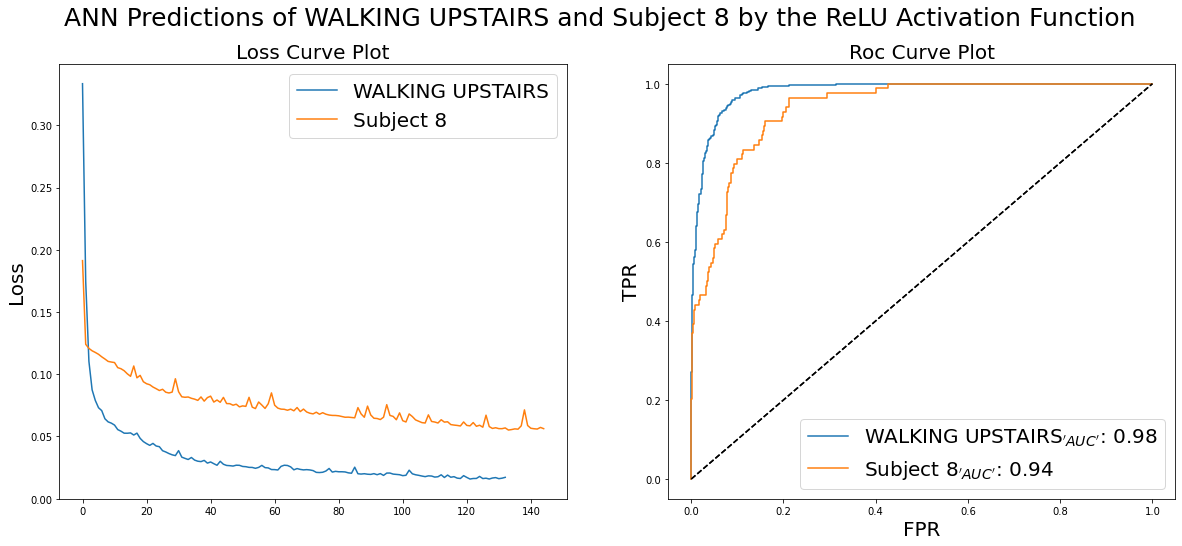

In [7]:
target_var = 'label'
target_class = 'WALKING_UPSTAIRS'
X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train = (rdf_train[target_var] == target_class).values
y_test = (rdf_test[target_var] == target_class).values
print(target_class)

the_auc = 'AUC'

loss_array = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

activation_fun = 'relu'

print('Activation Function =', activation_fun, '\n')

clf_wu = MLPClassifier(activation=activation_fun, learning_rate = 'constant', hidden_layer_sizes=(100,200,), max_iter=3000, random_state=42)

clf_wu.fit(X_train, y_train)

y_pred = clf_wu.predict(X_test)

y_score = clf_wu.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

loss_array.append(((fpr,tpr), clf_wu.loss_curve_))

ax[0].plot(clf_wu.loss_curve_, label="{}".format(target_class.replace('_',' ')))
ax[1].plot(fpr, tpr, label='{}$_{x}$: '.format(target_class.replace('_',' '), x={the_auc}) + str(round(roc_auc, 2))) #. to avoid visualizing multiple subscripts preserving distance (space doesn't work)
ax[1].plot([0,1], [0,1], 'k--')


print('ROC AUC {}'.format(roc_auc))
print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))
print('########################\n')

####################################################

target_var = 'individuals'
target_class = 8

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

loss_array = []

activation_fun = 'relu'

print(target_class)
print('Activation Function =', activation_fun, '\n')

clf8 = MLPClassifier(activation=activation_fun, learning_rate = 'constant', hidden_layer_sizes=(100,200,), max_iter=3000, random_state=42)

clf8.fit(X_train, y_train)

y_pred = clf8.predict(X_test)

y_score = clf8.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

loss_array.append(((fpr,tpr), clf8.loss_curve_))

ax[0].plot(clf8.loss_curve_, label="{}".format('Subject 8'))
ax[1].plot(fpr, tpr, label='{}$_{x}$: '.format('Subject 8', x={the_auc}) + str(round(roc_auc, 2))) #. to avoid visualizing multiple subscripts preserving distance (space doesn't work)
ax[1].plot([0,1], [0,1], 'k--')


print('ROC AUC {}'.format(roc_auc))
print('Accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('F1-score {}'.format(f1_score(y_test, y_pred, average=None)))
print(classification_report(y_test, y_pred))
print('########################\n')


ax[0].set_title('Loss Curve Plot', fontsize=20)
ax[1].set_title('Roc Curve Plot', fontsize=20)
ax[0].legend(fontsize=20)
ax[1].legend(fontsize=20)
ax[0].set_ylabel('Loss', fontsize=20)
ax[1].set_xlabel('FPR', fontsize=20)
ax[1].set_ylabel('TPR', fontsize=20)
plt.suptitle('ANN Predictions of WALKING UPSTAIRS and Subject 8 by the ReLU Activation Function', fontsize=25)

plt.show()

# EXPLAINING PREDICTION OF WALKING UPSTAIRS

## LIME

In [8]:
target_var = 'label'
target_class = 'WALKING_UPSTAIRS'
X_train, X_test = rdf_train_val[:], rdf_test_val[:]
y_train = (rdf_train[target_var] == target_class).values
y_test = (rdf_test[target_var] == target_class).values

In [9]:
np.argmax(y_test)

2

In [10]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=features_to_keep, class_names=['Not Upstairs', 'Upstairs'], discretize_continuous=False)
help(lime_explainer.explain_instance)

Help on method explain_instance in module lime.lime_tabular:

explain_instance(data_row, predict_fn, labels=(1,), top_labels=None, num_features=10, num_samples=5000, distance_metric='euclidean', model_regressor=None) method of lime.lime_tabular.LimeTabularExplainer instance
    Generates explanations for a prediction.
    
    First, we generate neighborhood data by randomly perturbing features
    from the instance (see __data_inverse). We then learn locally weighted
    linear models on this neighborhood data to explain each of the classes
    in an interpretable way (see lime_base.py).
    
    Args:
        data_row: 1d numpy array or scipy.sparse matrix, corresponding to a row
        predict_fn: prediction function. For classifiers, this should be a
            function that takes a numpy array and outputs prediction
            probabilities. For regressors, this takes a numpy array and
            returns the predictions. For ScikitClassifiers, this is
            `classifier.p

In [11]:
exp1 = lime_explainer.explain_instance(X_test[np.argmax(y_test)-1], clf_wu.predict_proba)
exp2 = lime_explainer.explain_instance(X_test[np.argmax(y_test)], clf_wu.predict_proba)

exp1.as_list()

[('10 tBodyAcc-max()-X', 0.03787166831661133),
 ('167 tBodyGyroJerk-mad()-X', -0.021082400295557715),
 ('74 tGravityAcc-arCoeff()-Z,1', -0.018682144309247375),
 ('53 tGravityAcc-min()-X', -0.018249425531346723),
 ('297 fBodyAcc-skewness()-X', 0.017572543300501814),
 ('331 fBodyAcc-bandsEnergy()-1,8', 0.01586465148154298),
 ('42 tGravityAcc-mean()-Y', -0.014443583028861652),
 ('427 fBodyGyro-std()-X', 0.013692210498365059),
 ('66 tGravityAcc-arCoeff()-X,1', -0.012463301022180113),
 ('411 fBodyAccJerk-bandsEnergy()-9,16', -0.008600983187161685)]

In [12]:
exp2.local_exp

{1: [(0, 0.06374211278338611),
  (1, -0.04054421267588693),
  (2, -0.03793617260267365),
  (7, 0.03618769122689605),
  (4, -0.03386599205732151),
  (6, 0.029597389225419504),
  (5, -0.028929785444878654),
  (3, -0.02355325666571143),
  (9, 0.020707913137305783),
  (11, 0.016602082452761662)]}

In [13]:
for el in clf_wu.predict_proba(X_test)[np.argmax(y_test)-1]:
    print(el)

1.0
1.1020203461496004e-17


In [14]:
for el in clf_wu.predict_proba(X_test)[np.argmax(y_test)]:
    print(el)

7.430738613378729e-05
0.9999256926138662


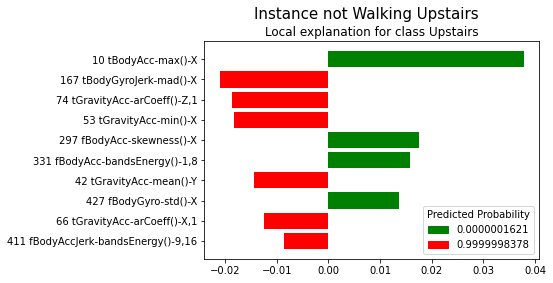

In [15]:
for i in range(1):
    exp1.as_pyplot_figure()
    plt.suptitle('Instance not Walking Upstairs', y=1, fontsize=15)
    red_patch = mpatches.Patch(color='red', label='0.9999998378')
    green_patch = mpatches.Patch(color='green', label='0.0000001621')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', title='Predicted Probability')

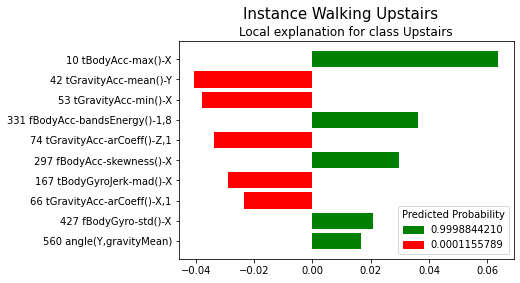

In [16]:
for i in range(1):
    exp2.as_pyplot_figure()
    plt.suptitle('Instance Walking Upstairs', y=1, fontsize=15)
    red_patch = mpatches.Patch(color='red', label='0.0001155789')
    green_patch = mpatches.Patch(color='green', label='0.9998844210')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', title='Predicted Probability')

In [17]:
exp1.show_in_notebook(show_table=True)

In [18]:
exp2.show_in_notebook(show_table=True)

## SHAP

In [19]:
shap.initjs()

In [20]:
def bb_predict_proba(X, clf):
    return clf.predict_proba(X)

In [21]:
f = lambda x: bb_predict_proba(x, clf_wu)[:, 1]

med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))

shap_explainer = shap.KernelExplainer(f, med)

In [22]:
np.argmax(y_test)

2

In [23]:
shap_values_single = shap_explainer.shap_values(X_test[np.argmax(y_test)], nsamples=1000)

In [24]:
shap_values_single

array([ 0.52045235,  0.02906635,  0.05417818,  0.03797602,  0.10307459,
       -0.04281157,  0.04302469,  0.09977886, -0.03324914,  0.04056777,
        0.15668517, -0.00881758])

In [25]:
nf = [x[1][:x[0]-2].replace(' ', '') for x in list(zip(pd.Series(features_to_keep).astype(str).str.find(')'), pd.Series(features_to_keep).astype(str).str[3:]))]

In [26]:
shap.force_plot(shap_explainer.expected_value, shap_values_single, features=X_test[np.argmax(y_test)], feature_names=nf)

In [27]:
np.argmax(y_test)

2

In [28]:
y_test[12+35:]

array([False, False, False, ..., False, False, False])

In [29]:
shap_values = shap_explainer.shap_values(X_test[0:100,:], nsamples=1000)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
shap.force_plot(shap_explainer.expected_value, shap_values, X_test[0:100,:], feature_names=features_to_keep)

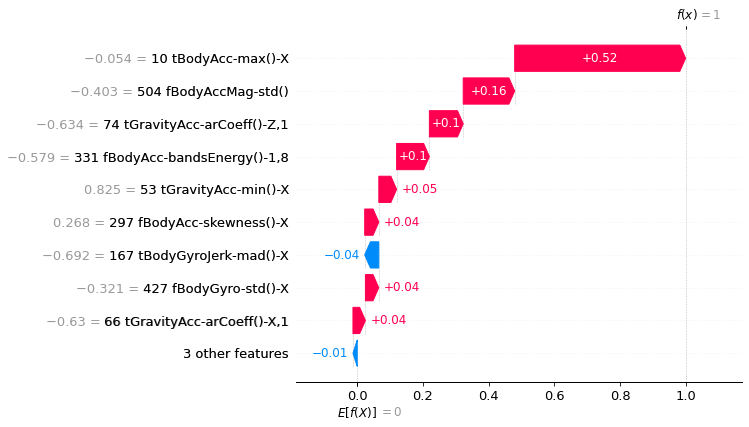

In [31]:
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                         base_values=shap_explainer.expected_value, 
                                         data=X_test[np.argmax(y_test)],  # added this line
                                         feature_names=features_to_keep)
                       )

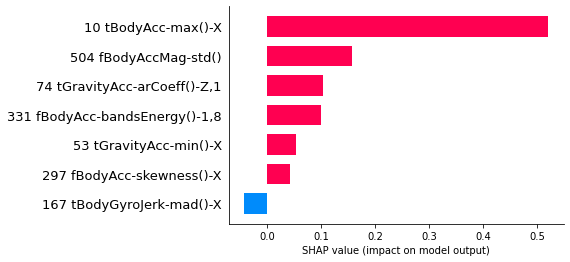

In [32]:
shap.bar_plot(shap_values_single, features=None, feature_names=features_to_keep, show=True)

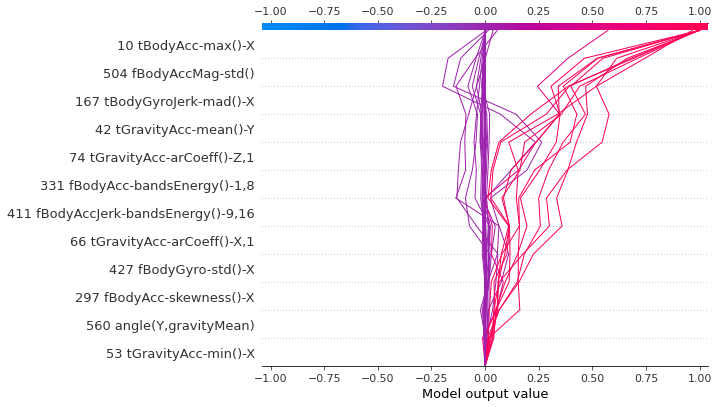

In [33]:
r = shap.decision_plot(shap_explainer.expected_value, shap_values, features_to_keep, return_objects=True)

# EXPLAINING PREDICTION OF SUBJECT 8

In [34]:
target_var = 'individuals'
target_class = 8

X = rdf[features_to_keep].values
y = (rdf[target_var] == target_class).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [35]:
np.argmax(y_test)

34

In [36]:
y_test[np.argmax(y_test)]

True

In [37]:
y_pred[np.argmax(y_test)]

True

## LIME

In [38]:
lime_explainer = LimeTabularExplainer(X_test, feature_names=features_to_keep, class_names=['Not Subject 8', 'Subject 8'], discretize_continuous=False)

exp1 = lime_explainer.explain_instance(X_test[np.argmax(y_test)-1], clf8.predict_proba)
exp2 = lime_explainer.explain_instance(X_test[np.argmax(y_test)], clf8.predict_proba)

exp2.local_exp

{1: [(11, -0.022944636007833065),
  (2, -0.019972784023030304),
  (3, -0.010659067194105434),
  (7, 0.00828777103266987),
  (0, -0.006543477157832786),
  (1, -0.006321250132355318),
  (6, -0.0043917897591293385),
  (9, -0.0040384760787049775),
  (4, 0.003930194662926341),
  (10, 0.003379814822202823)]}

In [39]:
for el in clf8.predict_proba(X_test)[np.argmax(y_test)-1]:
    print(el)

0.9259668417383977
0.07403315826160223


In [40]:
for el in clf8.predict_proba(X_test)[np.argmax(y_test)]:
    print(el)

0.1991363186944336
0.8008636813055664


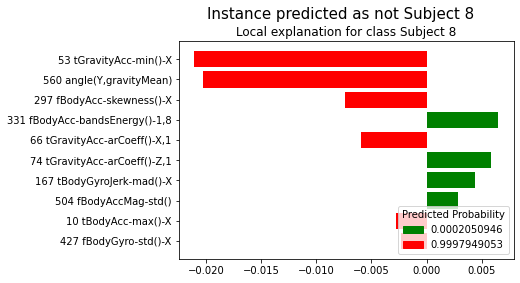

In [41]:
for i in range(1,2):
    exp1.as_pyplot_figure(label=i)
    plt.suptitle('Instance predicted as not Subject 8', y=1, fontsize=15)
    red_patch = mpatches.Patch(color='red', label='0.9997949053')
    green_patch = mpatches.Patch(color='green', label='0.0002050946')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', title='Predicted Probability')

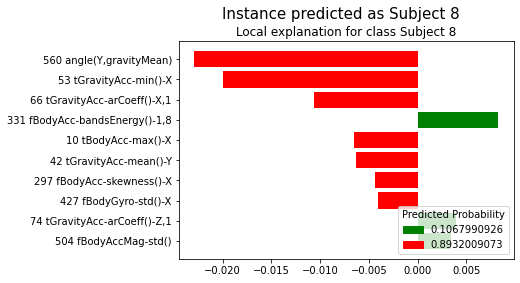

In [42]:
for i in range(1,2):
    exp2.as_pyplot_figure(label=i)
    plt.suptitle('Instance predicted as Subject 8', y=1, fontsize=15)
    red_patch = mpatches.Patch(color='red', label='0.8932009073')
    green_patch = mpatches.Patch(color='green', label='0.1067990926')
    plt.legend(handles=[green_patch, red_patch], loc='lower right', title='Predicted Probability')

In [43]:
exp1.show_in_notebook(show_table=True)

In [44]:
exp2.show_in_notebook(show_table=True)

## SHAP

In [45]:
f = lambda x: bb_predict_proba(x, clf8)[:, 1]

med = np.median(X_test, axis=0).reshape((1, X_test.shape[1]))

shap_explainer = shap.KernelExplainer(f, med)

In [46]:
shap_values_single = shap_explainer.shap_values(X_test[np.argmax(y_test)], nsamples=1000)

In [47]:
shap_values_single

array([-0.00433351,  0.18371814,  0.15884149,  0.15317338, -0.01013982,
        0.00574837,  0.06571955,  0.00141745,  0.00025279,  0.01386582,
       -0.00543912,  0.21415732])

In [48]:
nf = [x[1][:x[0]-2].replace(' ', '') for x in list(zip(pd.Series(features_to_keep).astype(str).str.find(')'), pd.Series(features_to_keep).astype(str).str[3:]))]

In [49]:
shap.force_plot(shap_explainer.expected_value, shap_values_single, features=X_test[np.argmax(y_test)], feature_names=nf)

In [50]:
np.argmax(y_test)

34

In [51]:
y_test[12+35:]

array([ True, False, False, ..., False, False, False])

In [52]:
shap_values = shap_explainer.shap_values(X_test[30:34+12,:], nsamples=1000)

  0%|          | 0/16 [00:00<?, ?it/s]

In [53]:
shap.force_plot(shap_explainer.expected_value, shap_values, X_test[30:35+13,:], feature_names=features_to_keep)

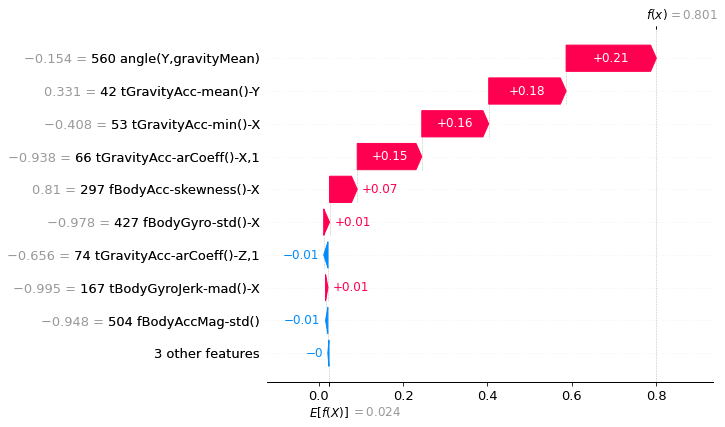

In [54]:
shap.waterfall_plot(shap.Explanation(values=shap_values_single, 
                                         base_values=shap_explainer.expected_value, 
                                         data=X_test[np.argmax(y_test)],  # added this line
                                         feature_names=features_to_keep)
                       )

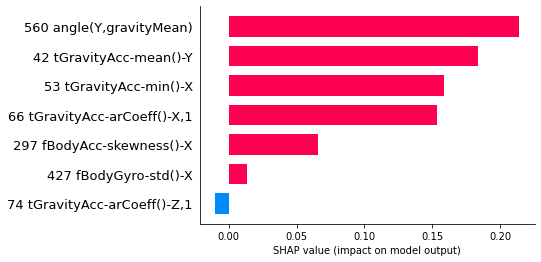

In [55]:
shap.bar_plot(shap_values_single, features=None, feature_names=features_to_keep, show=True)

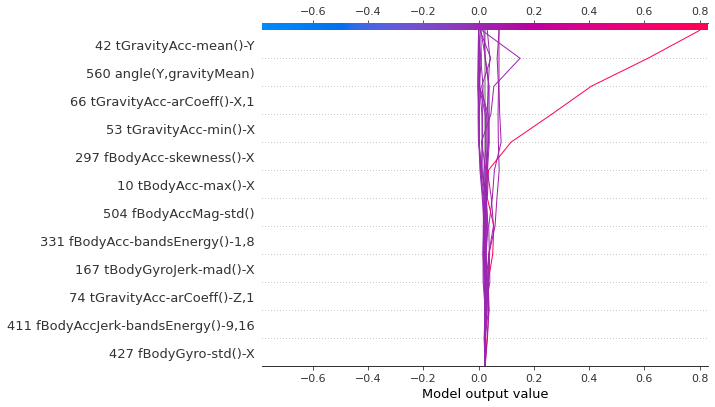

In [56]:
r = shap.decision_plot(shap_explainer.expected_value, shap_values, features_to_keep, return_objects=True)